# Cohort Analysis and Churn Prediction

This notebook serves as a demo to illustrate how to conduct cohort analysis and build a churn predictive model, with the goal to provide insights for the company in enhancing app features, optimizing app experience and designing user rentention strategy. For illustration purpose, the dataset used in this demo is synthesized based on users' activity log for an mobile app.

* [Part 1 : Churn Cohort Analysis by Month](#part1)
* [Part 2 : Churn Prediction](#part2)

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
import xgboost as xgb
import pickle

---
<a id="part1"></a>
## Part 1 : Churn Cohort Analysis by Month

Cohort analysis is a study on the activities of a particular cohort. New users who installed the app in the same month are grouped in the same cohort. They should experience similar onboarding experience and feature updates. A study of the evolution of a cohort's activity helps us to understand users' behavour in response to the app features along the time.

First, let us load and prepare users' activity data.

In [10]:
# load summary data extracted from SQL database
df_users = pd.read_csv('data/users.csv')
df_newusers = pd.read_csv('data/new_users.csv')

# pivot data
df_newusers.created_month = pd.to_datetime(df_newusers.created_month, format='%Y-%m')
df_users.created_month = pd.to_datetime(df_users.created_month, format='%Y-%m')
df_users.active_month = pd.to_datetime(df_users.active_month, format='%Y-%m')

df = df_users.assign(
    relative_month=
    (df_users.active_month.dt.year - df_users.created_month.dt.year) * 12 +
    (df_users.active_month.dt.month - df_users.created_month.dt.month) + 1
)

pivot = df.pivot(index='created_month', columns='relative_month', values='num_users')
pivot_p = pivot.div(df_newusers['num_users'].values, axis=0)
pivot_p.index = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

### How to interpret this heatmap

* If reading horizontally, it shows how user retention evolves over the time. It gives insight to the product quality, customer support, etc. 
* If reading vertically, it shows user retention in the n-th month since installation. In particular, the early months provide insights to users' onboarding experience. 
* For example, if we look at relative_month=2 vertically, rentention rate for the latter cohorts is generally higher than the earlier cohorts in the second month since installation. It can be explained by the fact that the app becomes more mature over the time and has growing capability to keep the new users.

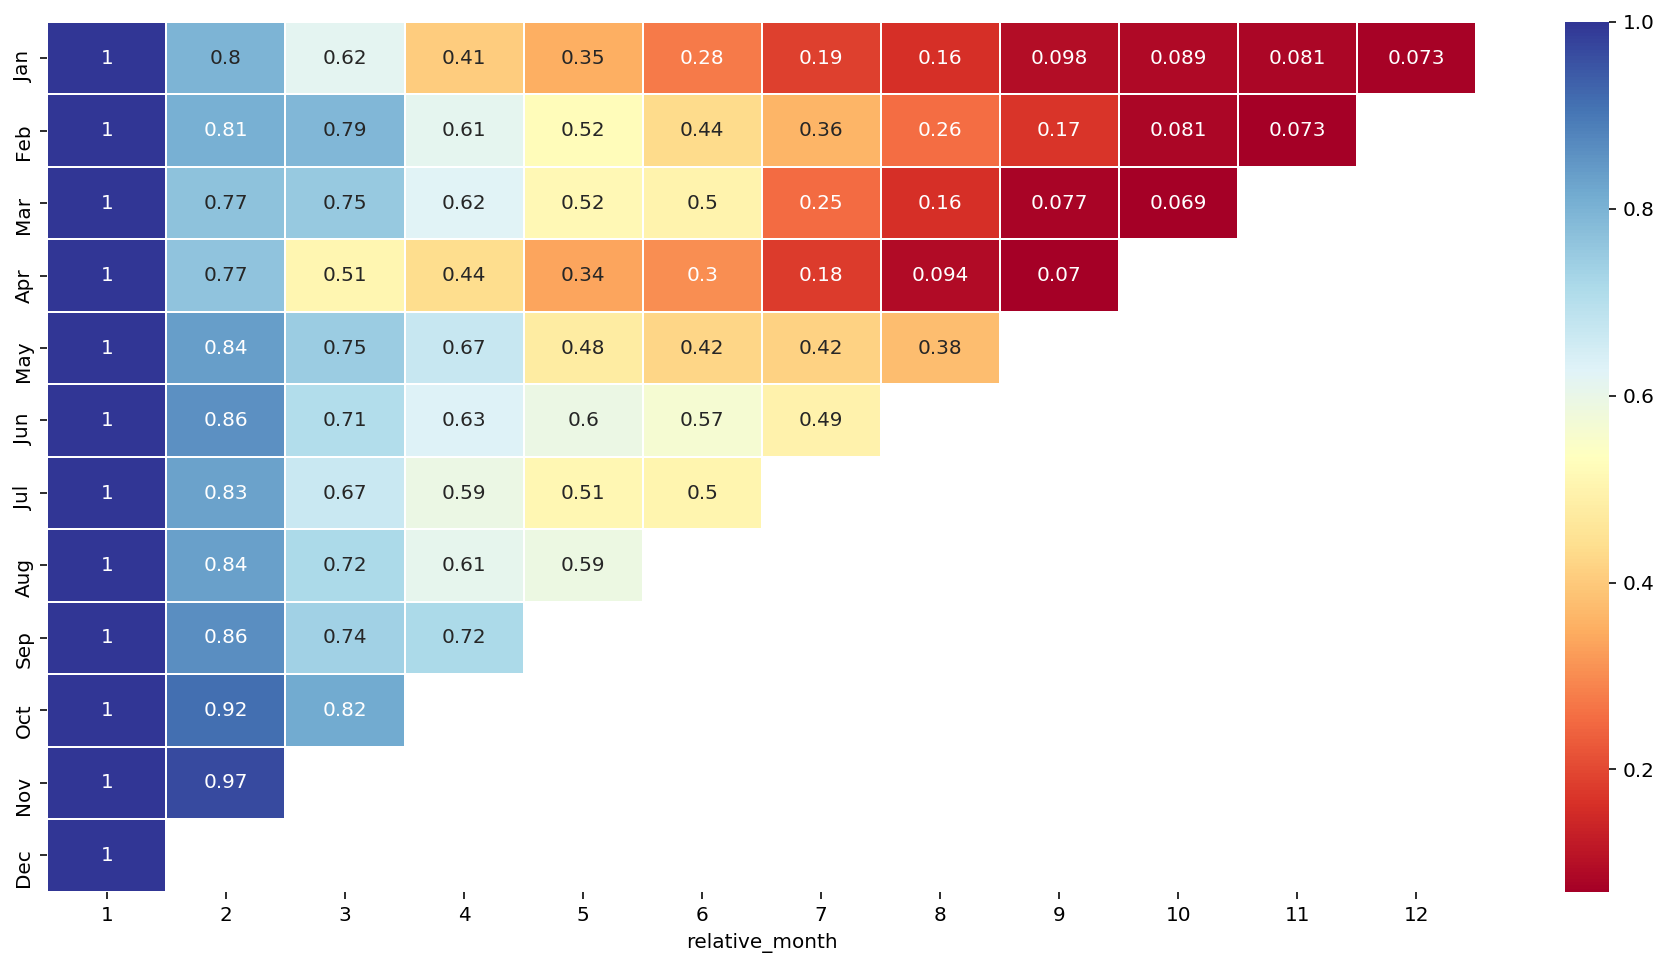

In [12]:
# plot heatmap
plt.figure(figsize=(16,8))
ax = sns.heatmap(pivot_p, annot=True, linewidths=.5, cmap="RdYlBu")
plt.savefig('plot/heatmap_by_month.png')
plt.show()

---
<a id="part2"></a>
## Part 2 : Churn Prediction

Next, we want to predict if a user will become inactive in the next 30 days. We consider these users as potential churn users and thus target stratgey to engage them to use the app again.

The goal of the model is to predict the churn score in the next 30 days of an app user based on his/her recent 90-day in-app behaviour. The predicted churn scores can help us understand how their in-app behaviour related to retention, and the risk of churn for each individual user. 

The model uses XGBoost algorithm and has been trained on features extracted from the activity log of 150k app users. Each user is labeled as 'churn' or 'non-churn'. A total of 24 features, such as total number of active days, number of events clicks, average session time, number of push notification received, block activities, browsing activity, are used to train the model. The observation period is the past 90 days and the prediction period is the next 30 days.  

The model achieves 0.84 accuracy and 0.83 AUC on the 20% test set.

In [3]:
# load data
df = pd.read_csv('data/user_logs.csv')
print(df.shape)

y = df.churn  
X = df.drop(columns=['uid', 'churn'])

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('\nShape of training set and test set')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# prepare data for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# set xgboost params
param = {
    'max_depth': 3,      # the maximum depth of each tree
    'eta': 0.3,          # the training step for each iteration
    'silent': 1,         # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}                 # the number of classes that exist in this datset
num_round = 10                      # the number of training iterations

# train xgb
xgb_model = xgb.train(param, dtrain, num_round)
preds = xgb_model.predict(dtest)
y_pred = np.asarray([np.argmax(line) for line in preds])

# evaluate on test set
evaluate(y_pred, y_test)

# save model 
filename = 'model/xgb_baseline_model.sav'
pickle.dump(xgb_model, open(filename, 'wb'))
print('Finish saving model!')

(158067, 26)

Shape of training set and test set
(126453, 24) (126453,) (31614, 24) (31614,)
Accuracy : 0.8369
AUC score : 0.8345
Precision : 0.7295
Recall : 0.8268
F1 score : 0.7751

Classification report : 
              precision    recall  f1-score   support

          0       0.90      0.84      0.87     20871
          1       0.73      0.83      0.78     10743

avg / total       0.84      0.84      0.84     31614


Confusion matrix : 
 [[17577  3294]
 [ 1861  8882]]
Finish saving model!


---
## More on XGBoost

### Why use XGBoost?

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. The two reasons to use XGBoost are its execution speed and model performance. XGBoost is generally faster compared to other implementations of gradient boosting. XGBoost also demomstrates very good performance for structured datasets on classification and regression predictive modeling problems in Kaggle competitions.


### Hyperparameter Tuning
To improve the performance of XGBoost, it's necessary to tune the model parameters. Some parameteres are tree-specific, such as `max_depth`, `min_child_weight`, `max_leaf_nodes`. Some are learning task parameters such as `objective` (which defines the loss function to be minimized), `eval_metric`, `seed`. Others relate to overall functioning, such as `nthread` (number of cores in the system for parelle processing),  `silent` (silent=1 means no running message). Please refer to [XGBoost Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html) for further details.

One way to perform hyperparameter tuning is to use scikit-learn API. XGBoost provides a wrapper class to allow models to be treated like classifiers `XGBClassifier` or regressors `XGBRegressor` in the scikit-learn framework. We can use `GridSearchCV` in scikit-learn to tune the set of parameters for `XGBClassifier`. A simple illustration below.

In [ ]:
# gridsearch
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'], # error evaluation for binaryclass training
              'learning_rate': [0.05, 0,3], #so called `eta` value, the training step for each iteration
              'max_depth': [5, 10], # the maximum depth of each tree
              'min_child_weight': [11],
              'silent': [1], # logging mode - quiet
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [10], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}

xgb_model = xgb.XGBClassifier()

grid = GridSearchCV(xgb_model, parameters, n_jobs=-1, 
                   cv=StratifiedKFold(y_train, n_folds=5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, missing=-999, n_estimators=10, nthread=4, objective=binary:logistic, seed=1337, silent=1, subsample=0.8 
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, missing=-999, n_estimators=10, nthread=4, objective=binary:logistic, seed=1337, silent=1, subsample=0.8 
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, missing=-999, n_estimators=10, nthread=4, objective=binary:logistic, seed=1337, silent=1, subsample=0.8 
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, missing=-999, n_estimators=10, nthread=4, objective=binary:logistic, seed=1337, silent=1, subsample=0.8 
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, missing=-999, n_estimators=10, nthread=4, objective=binary:logistic, seed=1337, silent=1, subsample=0.8 
[CV] colsa

In [ ]:
# cv results
print('Best param: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))